In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel


In [2]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the UniXcoder model and tokenizer
model_name = "microsoft/unixcoder-base-nine"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(51416, 768, padding_idx=1)
    (position_embeddings): Embedding(1026, 768, padding_idx=1)
    (token_type_embeddings): Embedding(10, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (

In [3]:
# Load your dataset containing coding questions
data = pd.read_csv(r"C:\Users\LENOVO T 470S\Downloads\Sample_Dataset(Java).csv", encoding='ISO-8859-1')
df = pd.DataFrame(data)

# Display the first few rows of the dataset
df.head()


,Question,Correct Solution
0,Reverse a String,public String reverseString(String s) {\n r...
1,Reverse a String,public String reverseString(String s) {\n S...
2,Reverse a String,public String reverseString(String s) {\n i...
3,Reverse a String,public String reverseString(String s) {\n S...
4,Reverse a String,public String reverseString(String s) {\n c...


In [4]:
# Function to encode data in batches for questions only
def encode_data_batch(df, model, tokenizer, device, start_row, end_row):
    nl_embeddings = []
    
    for i in range(start_row, end_row):
        # Encode natural language (question)
        nl = df['Correct Solution'][i]  # Assuming 'Question' is the column name for questions
        inputs = tokenizer(nl, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            nl_embedding = model(**inputs).last_hidden_state.mean(dim=1)  # Mean pooling to get a single vector
        nl_embeddings.append(nl_embedding.cpu().detach().numpy())
        
    return nl_embeddings


In [5]:
# Parameters
start_row = 0
batch_size = 300  # Number of rows to encode in each batch

# List to store encoded embeddings
all_nl_embeddings = []

# Iterate over the rows in batches and encode the questions
while start_row < len(df):
    end_row = min(start_row + batch_size, len(df))
    nl_embeddings_batch = encode_data_batch(df, model, tokenizer, device, start_row, end_row)
    
    all_nl_embeddings.extend(nl_embeddings_batch)
    
    # Clear memory
    nl_embeddings_batch = []
    
    # Update start_row for the next batch
    start_row = end_row


In [6]:
# Flatten the embeddings
flatten_nl_embeddings = np.array(all_nl_embeddings).reshape(len(all_nl_embeddings), -1)

# Create a DataFrame for the embeddings
nl_embed_data = pd.DataFrame(flatten_nl_embeddings, columns=[f'nl_embedding_{i}' for i in range(flatten_nl_embeddings.shape[1])])

# Save the embeddings to a CSV file
nl_embed_data.to_csv('codebert_embeddings.csv', index=False)

# Display the final DataFrame
print(nl_embed_data)


     nl_embedding_0  nl_embedding_1  nl_embedding_2  nl_embedding_3  \
0         -0.928577       -0.875321       -1.163469        1.666472   
1         -0.245723       -0.692561       -1.772530        0.249044   
2         -1.029692       -1.560707       -1.517062        0.971436   
3         -1.436489       -1.852267       -0.791643       -0.340749   
4         -0.284379       -2.881096       -2.906338       -0.779683   
..              ...             ...             ...             ...   
145       -0.583543        1.044930        0.018577       -0.381464   
146       -0.400492        1.133074       -0.606485        0.452624   
147       -0.757648        1.037906       -0.057161       -0.029770   
148       -0.459952        0.919552        0.208547       -0.188800   
149       -0.724482        0.849289        0.080915       -0.045179   

     nl_embedding_4  nl_embedding_5  nl_embedding_6  nl_embedding_7  \
0          1.968327       -0.302250       -0.873944        0.307057   
1    

In [7]:
from sklearn.cluster import DBSCAN

In [8]:
# Assuming you already have nl_embed_data DataFrame with embeddings
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit DBSCAN and get cluster labels
dbscan_labels = dbscan.fit_predict(nl_embed_data)

# Add the cluster labels to the nl_embed_data DataFrame
nl_embed_data['Cluster'] = dbscan_labels

# Display the DataFrame with cluster labels
print(nl_embed_data)

# Optionally, save the DataFrame with cluster labels to a CSV file
nl_embed_data.to_csv('codeBERT_dbscan.csv', index=False)


     nl_embedding_0  nl_embedding_1  nl_embedding_2  nl_embedding_3  \
0         -0.928577       -0.875321       -1.163469        1.666472   
1         -0.245723       -0.692561       -1.772530        0.249044   
2         -1.029692       -1.560707       -1.517062        0.971436   
3         -1.436489       -1.852267       -0.791643       -0.340749   
4         -0.284379       -2.881096       -2.906338       -0.779683   
..              ...             ...             ...             ...   
145       -0.583543        1.044930        0.018577       -0.381464   
146       -0.400492        1.133074       -0.606485        0.452624   
147       -0.757648        1.037906       -0.057161       -0.029770   
148       -0.459952        0.919552        0.208547       -0.188800   
149       -0.724482        0.849289        0.080915       -0.045179   

     nl_embedding_4  nl_embedding_5  nl_embedding_6  nl_embedding_7  \
0          1.968327       -0.302250       -0.873944        0.307057   
1    

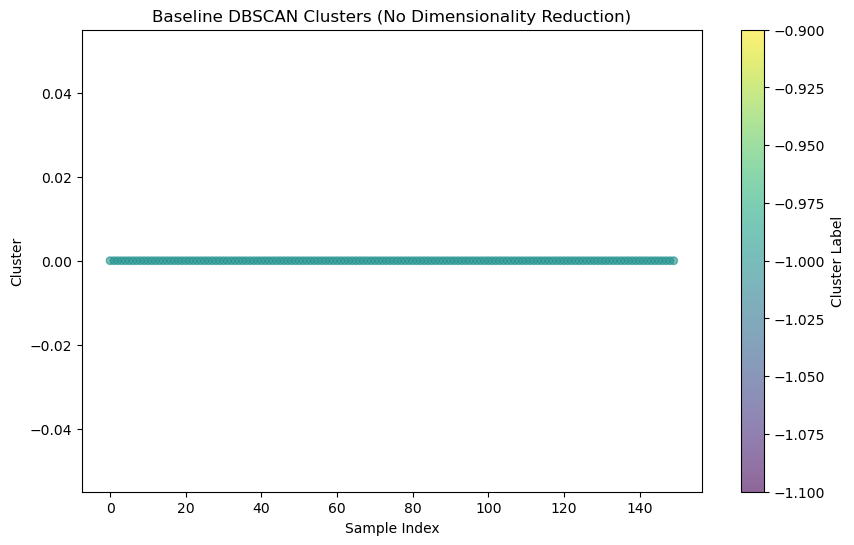

In [9]:
import matplotlib.pyplot as plt

# Plot the baseline DBSCAN clusters (no dimensionality reduction)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(nl_embed_data)), [0]*len(nl_embed_data), c=nl_embed_data['Cluster'], cmap='viridis', s=30, alpha=0.6)
plt.colorbar(label="Cluster Label")
plt.title("Baseline DBSCAN Clusters (No Dimensionality Reduction)")
plt.xlabel("Sample Index")
plt.ylabel("Cluster")
plt.show()


In [10]:
import umap

# Initialize UMAP with desired parameters
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', random_state=42)

# Fit and transform the embeddings
umap_embeddings = umap_model.fit_transform(nl_embed_data)

# Create a DataFrame from UMAP embeddings
umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])

# Display the UMAP DataFrame
print(umap_df)


D:\Anaconda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


        UMAP1      UMAP2
0    0.729891   5.161791
1    0.655241   5.294484
2    0.590968   4.920109
3    0.684262   5.208216
4    0.581478   5.331494
..        ...        ...
145 -1.575127  10.171245
146 -1.690294  10.050338
147 -1.669969  10.080461
148 -1.702658  10.158201
149 -1.566792  10.190472

[150 rows x 2 columns]


In [11]:

import numpy as np

# Initialize DBSCAN with desired parameters
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit DBSCAN to the UMAP embeddings
dbscan_labels = dbscan.fit_predict(umap_df)

# Add the cluster labels to the UMAP DataFrame
umap_df['Cluster'] = dbscan_labels

# Display the DataFrame with cluster labels
print(umap_df)


        UMAP1      UMAP2  Cluster
0    0.729891   5.161791        0
1    0.655241   5.294484        0
2    0.590968   4.920109        0
3    0.684262   5.208216        0
4    0.581478   5.331494        0
..        ...        ...      ...
145 -1.575127  10.171245       13
146 -1.690294  10.050338       13
147 -1.669969  10.080461       13
148 -1.702658  10.158201       13
149 -1.566792  10.190472       13

[150 rows x 3 columns]


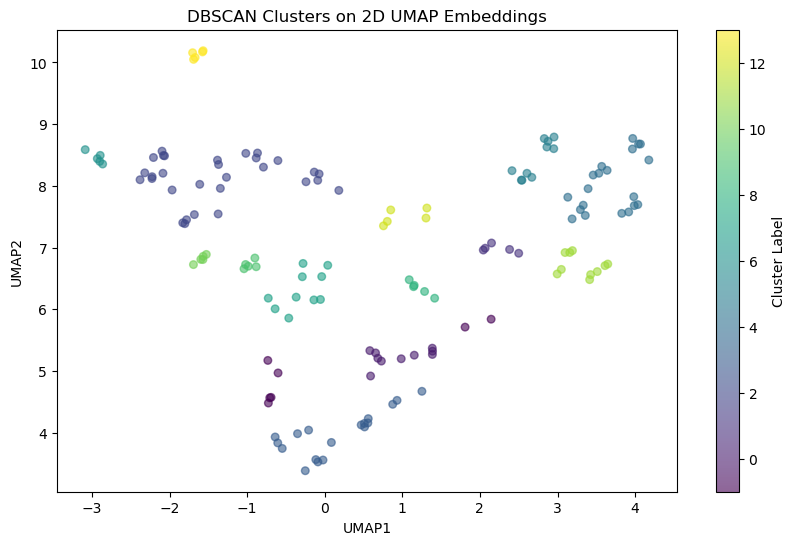

In [12]:
# Plot the DBSCAN clusters on 2D UMAP embeddings
plt.figure(figsize=(10, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df['Cluster'], cmap='viridis', s=30, alpha=0.6)
plt.colorbar(label="Cluster Label")
plt.title("DBSCAN Clusters on 2D UMAP Embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


In [13]:
# Initialize UMAP with 3 components for 3D embeddings
umap_model = umap.UMAP(n_neighbors=15, n_components=3, metric='euclidean', random_state=42)

# Fit and transform the embeddings
umap_embeddings = umap_model.fit_transform(nl_embed_data)

# Create a DataFrame from UMAP embeddings
umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2', 'UMAP3'])

# Display the UMAP DataFrame
print(umap_df)

D:\Anaconda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


        UMAP1     UMAP2     UMAP3
0    1.718519  2.427294  5.593943
1    1.822622  2.550232  5.497230
2    1.816451  2.713917  5.888608
3    1.695338  2.326644  5.536517
4    1.819573  2.412802  5.637442
..        ...       ...       ...
145  0.254382  3.395122  3.531596
146  0.356101  3.442836  3.460659
147  0.436798  3.442019  3.344193
148  0.336832  3.470099  3.447192
149  0.374345  3.519076  3.409672

[150 rows x 3 columns]


In [14]:
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit DBSCAN to the 3D UMAP embeddings
dbscan_labels = dbscan.fit_predict(umap_df)

# Add the cluster labels to the UMAP DataFrame
umap_df['Cluster'] = dbscan_labels

# Display the UMAP DataFrame with cluster labels
print(umap_df)

        UMAP1     UMAP2     UMAP3  Cluster
0    1.718519  2.427294  5.593943        0
1    1.822622  2.550232  5.497230        0
2    1.816451  2.713917  5.888608        0
3    1.695338  2.326644  5.536517        0
4    1.819573  2.412802  5.637442        0
..        ...       ...       ...      ...
145  0.254382  3.395122  3.531596       14
146  0.356101  3.442836  3.460659       14
147  0.436798  3.442019  3.344193       14
148  0.336832  3.470099  3.447192       14
149  0.374345  3.519076  3.409672       14

[150 rows x 4 columns]


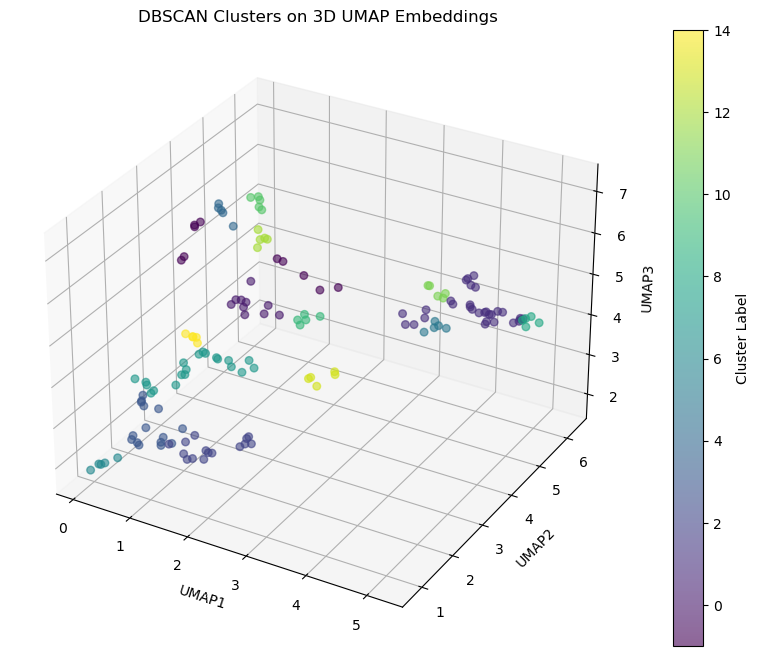

In [15]:
from mpl_toolkits.mplot3d import Axes3D

# Plot the DBSCAN clusters on 3D UMAP embeddings
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], umap_df['UMAP3'], c=umap_df['Cluster'], cmap='viridis', s=30, alpha=0.6)
plt.colorbar(sc, label="Cluster Label")
ax.set_title("DBSCAN Clusters on 3D UMAP Embeddings")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
plt.show()


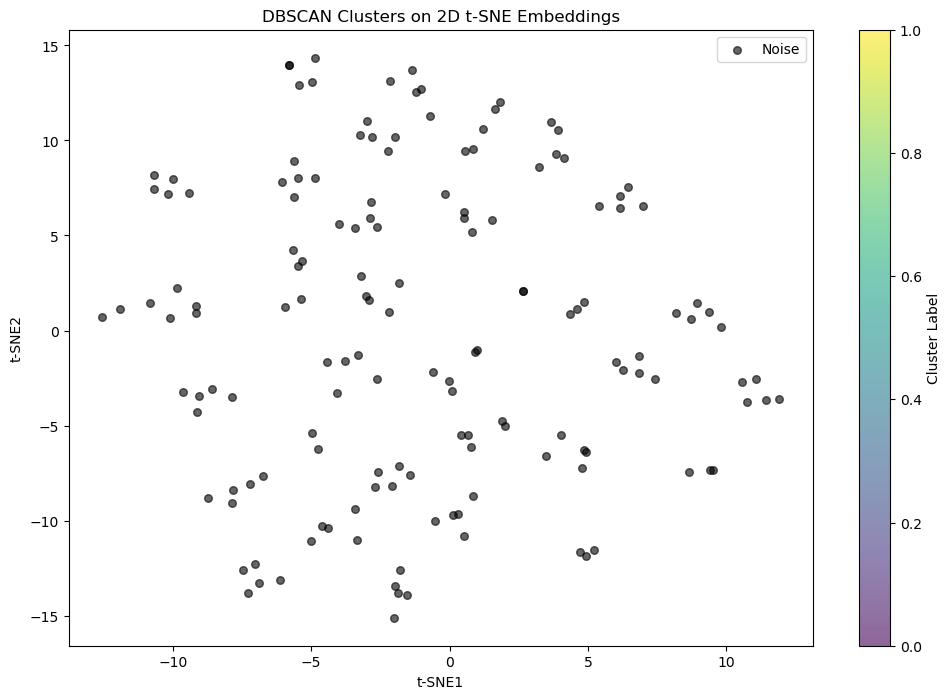

In [17]:
from sklearn.manifold import TSNE


tsne_model = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne_model.fit_transform(nl_embed_data)

# Create a DataFrame from the t-SNE embeddings
tsne_df = pd.DataFrame(tsne_embeddings, columns=['tSNE1', 'tSNE2'])

# Apply DBSCAN clustering to the 2D t-SNE embeddings
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_df)

# Add the DBSCAN cluster labels to the t-SNE DataFrame
tsne_df['DBSCAN_Cluster'] = dbscan_labels

# Handle the noise points (label -1) in DBSCAN clustering
noise_points = tsne_df['DBSCAN_Cluster'] == -1
non_noise_points = ~noise_points

# Plot DBSCAN clusters on 2D t-SNE embeddings with special color for noise points
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)  # Corrected here: no 'projection' argument needed for 2D plot

# Plot noise points with a distinct color (e.g., black)
ax.scatter(tsne_df[noise_points]['tSNE1'], tsne_df[noise_points]['tSNE2'], 
           color='k', label='Noise', s=30, alpha=0.6)

# Plot other clusters
sc = ax.scatter(tsne_df[non_noise_points]['tSNE1'], tsne_df[non_noise_points]['tSNE2'], 
                c=tsne_df[non_noise_points]['DBSCAN_Cluster'], cmap='viridis', s=30, alpha=0.6)

plt.colorbar(sc, label="Cluster Label")
ax.set_title("DBSCAN Clusters on 2D t-SNE Embeddings")
ax.set_xlabel("t-SNE1")
ax.set_ylabel("t-SNE2")
plt.legend()
plt.show()

         tSNE1      tSNE2      tSNE3
0   -57.839817 -55.789810   4.297633
1   -31.125750 -59.248096  -3.866841
2   -38.082706 -48.892673   9.756589
3   -51.904728 -71.425102 -12.276739
4   -32.568287 -81.612099   1.928216
..         ...        ...        ...
145 -62.346798  35.571796  68.251045
146 -44.065559  23.526154  60.093250
147 -43.332150  47.304295  61.657345
148 -42.160507  33.103241  80.406677
149 -53.687496  52.766762  80.427635

[150 rows x 3 columns]
         tSNE1      tSNE2      tSNE3  DBSCAN_Cluster
0   -57.839817 -55.789810   4.297633              -1
1   -31.125750 -59.248096  -3.866841              -1
2   -38.082706 -48.892673   9.756589              -1
3   -51.904728 -71.425102 -12.276739              -1
4   -32.568287 -81.612099   1.928216              -1
..         ...        ...        ...             ...
145 -62.346798  35.571796  68.251045              -1
146 -44.065559  23.526154  60.093250              -1
147 -43.332150  47.304295  61.657345              -1
14

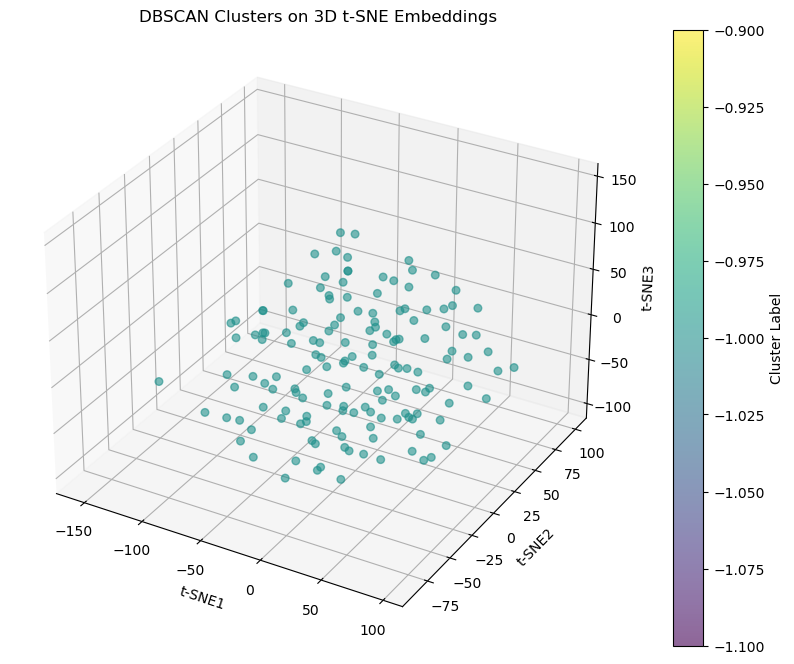

In [18]:
# Apply t-SNE for 3D dimensionality reduction
tsne_model = TSNE(n_components=3, random_state=42)
tsne_embeddings = tsne_model.fit_transform(nl_embed_data)

# Create a DataFrame from the t-SNE embeddings
tsne_df = pd.DataFrame(tsne_embeddings, columns=['tSNE1', 'tSNE2', 'tSNE3'])

# Display the t-SNE DataFrame
print(tsne_df)

# Apply DBSCAN clustering to the 3D t-SNE embeddings
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_df)

# Add the DBSCAN cluster labels to the t-SNE DataFrame
tsne_df['DBSCAN_Cluster'] = dbscan_labels

# Display the t-SNE DataFrame with DBSCAN labels
print(tsne_df)

# Plot DBSCAN clusters on 3D t-SNE embeddings
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(tsne_df['tSNE1'], tsne_df['tSNE2'], tsne_df['tSNE3'], c=tsne_df['DBSCAN_Cluster'], cmap='viridis', s=30, alpha=0.6)
plt.colorbar(sc, label="Cluster Label")
ax.set_title("DBSCAN Clusters on 3D t-SNE Embeddings")
ax.set_xlabel("t-SNE1")
ax.set_ylabel("t-SNE2")
ax.set_zlabel("t-SNE3")
plt.show()
